# Contrastive Language Image Pre-Training (CLIP) on Radiology Objects in COntext (ROCO)

## Import libraries and data
Before starting executing the notebook, do the following steps:
- Go to "Runtime" > "Change type of runtime" and select a GPU-based runtime;
- Load the `resized_train.zip`, `caption_prediction_train.csv`, `concept_detection_train.csv`  files in the File folder.

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tfk.layers

Set the random seed for reproducibility:

In [4]:
seed = 24948989491

rng = np.random.default_rng(seed)
tf.random.set_seed(seed)

Extract the images from `resized_train.zip`:

In [ ]:
!unzip resized_train.zip

Load textual data:

In [5]:
# Load the captions
captions = pd.read_csv("caption_prediction_train.csv",sep="\t", index_col="ID")

# Load the labels
labels = pd.read_csv("concept_detection_train.csv",sep="\t",index_col="ID")
# Each label string contains multiple labels separated by a semicolumn.
# Transform the strings in lists of labels.
labels["cuis"] = labels["cuis"].str.split(pat=";")

We explore the images to check if they are all 128x128 pixel and how many channels they have:

In [9]:
max_channels = 1
for i in labels.index:
  image_name = "resized_train/"+i+".jpg"
  img = Image.open(image_name)
  img = np.array(img)
  if img.ndim==3 and img.shape[2] > max_channels:
    max_channels = img.shape[2]
  # Check if the image has the expected resolution of 128x128
  if img.shape[0]!=128 or img.shape[1]!=128:
    print(f"Error in {image_name}: its resolution is " +
      f"{img.shape[0]}x{img.shape[1]}, while it should be 128x128")

print(f"The maximum number of channels is {max_channels}.")

The maximum number of channels is 3.


We import all the images, we shuffle them and we split them in training and test sets:

In [6]:
images = np.zeros((labels.shape[0],128,128,3),dtype="uint8")
count = 0
for i in labels.index:
  image_name = "resized_train/"+i+".jpg"
  img = tf.io.read_file(image_name)
  images[count]= tf.io.decode_image(img, channels=3)
  count = count + 1

In [7]:
train_idx = np.sort(rng.choice(range(labels.shape[0]),
                               size=int(0.8*labels.shape[0]), replace=False))
test_idx = np.delete(range(labels.shape[0]), train_idx)

images_train = images[train_idx]
images_test = images[test_idx]
# Delete the variable to free a lot of space in the RAM
images=None

Following the division of the images, we split also the labels and the captions in training and test sets.

In [8]:
# Function to get the ordered IDs of the images in the datasets.
'''
train_idx = np.char.strip(
    np.array(images_train.file_paths),"./resized_train/.jpg")
test_idx = np.char.strip(
    np.array(images_train.file_paths),"./resized_train/.jpg")
'''

captions_train = captions.iloc[train_idx]
captions_test = captions.iloc[test_idx]
labels_train = labels.iloc[train_idx]
labels_test = labels.iloc[test_idx]

## Build the CLIP model

Set the constants for the CLIP model.

In [9]:
# The size of the images in input.
input_shape = (128,128,3)
# The vocabulary size for the words in the captions.
vocab_size = 20000
# The maximum number of words in a caption. Captions with a smaller number of
# words are padded in the TextVectorization layer.
sequence_length = 400
# Dimension of the vectors representing each caption after the embedding.
embed_dim = 128
# Number of attention heads in each attention block.
num_heads = 4
# Dimension of the central layer of the feed forward NN.
latent_dim = 1024
# The final embedding dimensions for both texts and images
final_embed_dim = 128

### Define the CNN

We define the convolutional block, which will be the base block for the CNN.

In [10]:
def convolutional_block(x, filters, kernel):
  '''
  A function building a convolutional block in a neural network, composed of a
  convolutional layer and a max pooling layer. It takes as parameters the number
  of filters for the convolutional operation and the size of the convolutional
  kernel.

  Input shape: (None, h, w, channels)
  Output shape: (None, h/2, w/2, filters)
  '''
  # Apply convolution operation to the input x
  x = tfkl.Conv2D(
      filters,
      kernel,
      strides=1,
      padding='same',
      activation='relu'
  )(x)
  # Apply max pooling operation to the convolution output
  x = tfkl.MaxPooling2D()(x)

  return x

We define the convolutional neural network, which is composed of a series of convolutional blocks and a flatten block.

In [11]:
def get_convolutional_neural_network(blocks, filters, kernel):
  '''
  A function generating a Keras Model of a Convolutional Neural Network (CNN)
  with the specified number of convolutional blocks, number of filters for each
  convolutional block and kernel size.

  Input shape: (None, h, w, channels)
  Output shape: (None, h/(2^blocks)*w/(2^blocks)*filters*blocks)
  '''
  inputs = tfkl.Input(shape=input_shape, name='CNN_input')
  x = tfkl.Normalization(name="CNN_normalization")(inputs)
  # Extract features via convolution and pooling operations
  for b in range(blocks):
      x = convolutional_block(x, filters*(b+1), kernel)
  x = tfkl.Flatten(name="CNN_flatten")(x)
  # Create the Keras model
  model = tfk.Model(inputs=inputs, outputs=x, name="Convolutional NN")
  return model

### Define the Text Transformer

In [12]:
class TokenAndPositionEmbedding(tfkl.Layer):
  '''
  A custom Keras Layer implementing the token and position embedding block.
  It consists of two embedding layers, one for the tokens and one for the
  position of the token.
  '''
  def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
    super().__init__(**kwargs)
    # Embedding layer for the token
    self.token_emb = tfkl.Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    # Embedding layer for the position
    self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)
    self.maxlen = maxlen

  def call(self, x):
    '''
    Input shape: (None, sequence_length)
    Output shape: (None, sequence_length, embed_dim)
    '''
    # Create a tensor with positions from 0 to maxlen-1
    positions = tf.range(start=0, limit=self.maxlen, delta=1)
    # Embed the positions
    positions = self.pos_emb(positions)
    # Embed the tokens
    x = self.token_emb(x)
    # Add the token and position embeddings
    return x + positions

In [13]:
class TransformerEncoderBlock(tfkl.Layer):
  '''
  A custom Keras Layer implementing a block in the Transformer encoder
  architecture.
  It consists of:
  - Multi-head self-attention layer
  - Feed-forward network with two dense layers and ReLU activation
  - Two normalization layers
  - Two dropout layers
  '''
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
    super().__init__(**kwargs)
    self.att =tfkl.MultiHeadAttention(num_heads=num_heads,key_dim=embed_dim)
    self.ffn = tfk.Sequential(
        [
            tfkl.Dense(ff_dim, activation="relu"),
            tfkl.Dense(embed_dim)
        ]
    )
    self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
    self.dropout1 = tfkl.Dropout(rate)
    self.dropout2 = tfkl.Dropout(rate)

  def call(self, inputs, training):
    '''
    Input shape: (None, sequence_length, embed_dim)
    Output shape: (None, sequence_length, embed_dim)
    '''
    # Self-attention
    attn_output = self.att(inputs, inputs)
    # Apply dropout to the attention output
    attn_output = self.dropout1(attn_output, training=training)
    # Add the attention output to the input and normalize
    out1 = self.layernorm1(inputs + attn_output)
    # Feed-forward
    ffn_output = self.ffn(out1)
    # Apply dropout to the feed-forward output
    ffn_output = self.dropout2(ffn_output, training=training)
    # Add the feed-forward output to the previous output and normalize
    return self.layernorm2(out1 + ffn_output)

In [14]:
def get_transformer_neural_network(blocks):
  '''
  A function generating a Keras Model of a transfomer encoder with a specified
  number of blocks.

  Input shape: (None, sequence_length)
  Output shape: (None, embed_dim)
  '''
  inputs = tfkl.Input(shape=(sequence_length), name='transformer_input')
  x = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim,
                                name="token_position_embedding")(inputs)
  for i in range(blocks):
    x = TransformerEncoderBlock(embed_dim, num_heads, latent_dim,
                                name="transformer_encoder_block"+str(i+1))(x)
  x = tfkl.GlobalAveragePooling1D(name="transformer_global_average_pooling")(x)
  model = tfk.Model(inputs=inputs, outputs=x, name="Transformer")
  return model

### Define the CLIP Model

In [15]:
class CLIPConnector(tfkl.Layer):
  '''
  A custom Keras Layer for connecting the outputs of a CNN and a Transformer
  model using the CLIP similarity computation.
  '''
  def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.t = self.add_weight(name="temperature", trainable=True)
        self.CNN_dense = tfkl.Dense(final_embed_dim, activation=None,
                                    name="CNN_dense")
        self.transformer_dense = tfkl.Dense(final_embed_dim, activation=None,
                                            name="transformer_dense")

  def call(self, CNN_output, transformer_output):
    '''
    Input shape:
    - CNN_output: (None, CNN_output_size)
    - transformer_output: (None, embed_dim)
    Output shape: (None, None)
    '''
    # Use Dense layers to obtain the same embedding dimensions for the CNN and
    # transformer encodings.
    CNN_output_final_embed = self.CNN_dense(CNN_output)
    transformer_output_final_embed = self.transformer_dense(transformer_output)

    # l2 normalization of both embeddings.
    CNN_output_final_embed_norm = tf.math.l2_normalize(
        CNN_output_final_embed, axis=-1)
    transformer_output_final_embed_norm = tf.math.l2_normalize(
        transformer_output_final_embed, axis=-1)

    # Computation of the cosine distance between the embeddings and
    # multiplication for a trainable temperature parameter.
    similarity_matrix = tf.linalg.matmul(transformer_output_final_embed_norm,
                                         CNN_output_final_embed_norm,
                                         transpose_a=False,
                                         transpose_b=True)*tf.math.exp(self.t)

    return similarity_matrix

In [16]:
CNN = get_convolutional_neural_network(blocks=3, filters=64, kernel=5)
transformer = get_transformer_neural_network(blocks=3)

similarity_matrix = CLIPConnector(name="CLIP_connector")(CNN.output, transformer.output)

CLIP=tfk.Model(inputs=[CNN.input, transformer.input], outputs=similarity_matrix,
                 name="CLIP")
CLIP.summary()

Model: "CLIP"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CNN_input (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 CNN_normalization (Normalizati  (None, 128, 128, 3)  7          ['CNN_input[0][0]']              
 on)                                                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  4864        ['CNN_normalization[0][0]']      
                                )                                                              

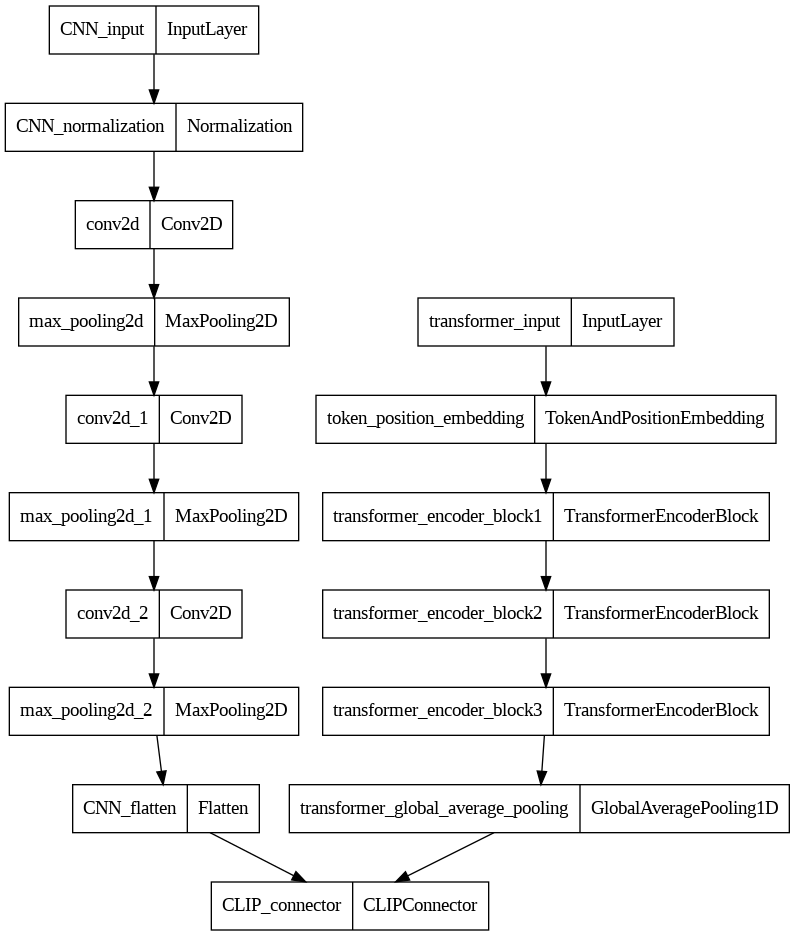

In [17]:
tfk.utils.plot_model(CLIP)

## Training and validation

In [18]:
learning_rate = 1e-4
optimizer = tfk.optimizers.Adam(learning_rate)
EPOCHS = 2
BATCH_SIZE = 64

### Define the custom loss function

In [19]:
def CLIP_loss_fn(y_true, y_pred):
  '''
  Custom loss function for the CLIP model. It computes the similarity between
  the output matrix of CLIP and the identity matrix. To do this, it exploits the
  cross-entropy loss function on both axes of the output matrix and then
  averages the two results.
  '''
  n = BATCH_SIZE
  labels = np.arange(n)
  loss_function = tfk.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction=tfk.losses.Reduction.SUM)
  loss_1 = loss_function(labels, y_pred)
  loss_2 = loss_function(labels, tf.transpose(y_pred))
  return (loss_1+loss_2)/2

### Train the model

In [20]:
'''
This code is performing text vectorization in TensorFlow's Keras library
(tf.keras or tfk). It defines a TextVectorization layer with a vocabulary
size of vocab_size, meaning it will only consider the top vocab_size most common
tokens in the input text data. The layer has an output mode of "int",
meaning it will return the vectorized representation of the text as integer
token indices. The output sequence length is set to sequence_length, meaning
each input text will be padded or truncated to sequence_length tokens.
The adapt method is called on the training captions, allowing the vectorization
layer to learn and update the tokenization and vocabulary mapping.
'''
vectorization = tfkl.TextVectorization(max_tokens=vocab_size, output_mode="int",
                                       output_sequence_length=sequence_length)
vectorization.adapt(captions)
captions_train_vect = vectorization(captions_train)
captions_test_vect = vectorization(captions_test)

In [ ]:
CLIP.compile(optimizer=optimizer, loss=CLIP_loss_fn)

history = CLIP.fit(
    x=[images_train, captions_train_vect],
    y=tf.zeros(len(train_idx),2),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
    #callbacks = [
    #    tfk.callbacks.EarlyStopping(mode='max', patience=5, restore_best_weights=True)
    #]
)